## Trader

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data

from sklearn.preprocessing import MinMaxScaler

import gymnasium as gym

from stable_baselines3 import PPO

2026-01-07 10:42:55.625933: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-07 10:42:55.727476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767778975.771363    8913 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767778975.783599    8913 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767778975.861049    8913 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

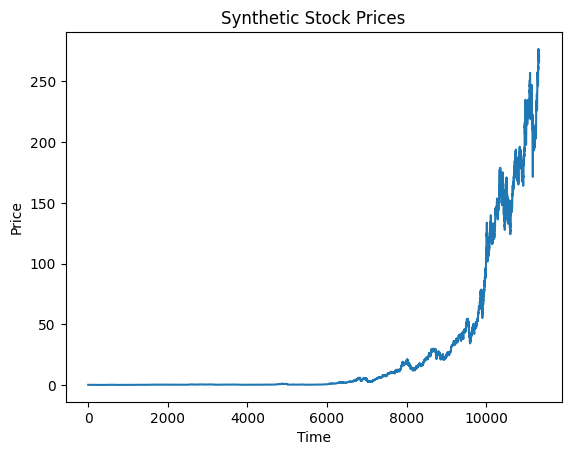

In [2]:
CSV_PATH = "./data/AAPL.csv"
TARGET_COL = "Open"
df = pd.read_csv(CSV_PATH)

plt.plot(df["Open"])
plt.title("Synthetic Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [3]:
df["Open_log_return"] = np.log(df["Open"] / df["Open"].shift(1))
df["Open_log_return"] = df["Open_log_return"].fillna(0.0)
combined_prices_scaled_df = df["Open_log_return"].to_frame()

In [4]:
import lstm.models as lsmodels

model_path = "final_rmse_lstm.pth"

class StockTradingEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, df_scaled, original_df, initial_balance=10000, trade_fee_pct=0.01):
        super().__init__()
        self.action_map = {
            0: ("HOLD", 0),
            1: ("BUY", 1),
            2: ("BUY", 5),
            3: ("BUY", 10),
            4: ("SELL", 1),
            5: ("SELL", 5),
            6: ("SELL", 10),
            }
            
        self.action_space = gym.spaces.Discrete(len(self.action_map))
        self.df_scaled = df_scaled 
        self.original_df = original_df 

        self.initial_balance = initial_balance
        self.trade_fee_pct = trade_fee_pct 

        self.balance = self.initial_balance 
        self.shares_held = 0 
        self.net_worth = self.initial_balance 
        self.last_net_worth = self.initial_balance 
        self.current_step = 0
        self.max_steps = len(df_scaled) - 1
        self.seq_len = 60
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        
        self.lstm_model = lsmodels.SimpleLSTMRegressor(lstm_layers=3, hidden_size1=96).to(self.device)
        self.lstm_model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.lstm_model.eval()
        
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(self._get_observation()),), dtype=np.float32)

    def _get_observation(self):
        current_price = self._get_current_price()
        net_worth = self.net_worth if self.net_worth > 0 else 1.0
        position_flag = 1.0 if self.shares_held > 0 else 0.0
        position_value = self.shares_held * current_price
        position_ratio = position_value / net_worth
        cash_ratio = self.balance / net_worth

        obs_space = np.array([
            position_flag,
            position_ratio,
            cash_ratio
        ], dtype=np.float32)

        # --------- Real LSTM 7 days ---------
        lstm_obs = np.zeros(7, dtype=np.float32)
        if self.current_step >= self.seq_len:
            raw_window = self.original_df['Close'].iloc[self.current_step - self.seq_len : self.current_step].values.reshape(-1, 1)
            input_tensor = torch.tensor(raw_window, dtype=torch.float32).unsqueeze(0).to(self.device)
            self.lstm_model.eval()
            with torch.no_grad():
                pred_price = self.lstm_model(input_tensor).item()
                lstm_obs[0] = (pred_price - current_price) / current_price

                temp_window = raw_window.copy()
                last_price = pred_price
                for j in range(1, 7):
                    temp_window = np.roll(temp_window, -1)
                    temp_window[-1] = last_price
                    input_tensor = torch.tensor(temp_window, dtype=torch.float32).unsqueeze(0).to(self.device)
                    with torch.no_grad():
                        last_price = self.lstm_model(input_tensor).item()
                        lstm_obs[j] = (last_price - current_price) / current_price

        market_obs = self.df_scaled.iloc[self.current_step].values.astype(np.float32)

        return np.concatenate([market_obs, obs_space, lstm_obs])

    def _get_current_price(self):
        return self.original_df['Open'].iloc[self.current_step]

    def _take_action(self, action):
        current_price = self._get_current_price()
        action_type, stocks_count = self.action_map[action]

        if action_type == "BUY":  
            available_cash_for_shares = self.balance / (1 + self.trade_fee_pct)

            max_affordable_shares = int(available_cash_for_shares // current_price) if current_price > 0 else 0
            if stocks_count>=max_affordable_shares:
                num_shares_to_buy = max_affordable_shares
            else:
                num_shares_to_buy = min(stocks_count, max_affordable_shares)

            if num_shares_to_buy > 0:
                cost = num_shares_to_buy * current_price * (1 + self.trade_fee_pct)
                self.shares_held += num_shares_to_buy
                self.balance -= cost

        elif action_type == "SELL":  
            if stocks_count >= self.shares_held:
                num_shares_to_sell = int(self.shares_held)
            else:
                num_shares_to_sell = min(stocks_count, int(self.shares_held))

            if num_shares_to_sell > 0:
                proceeds = num_shares_to_sell * current_price * (1 - self.trade_fee_pct)
                self.balance += proceeds
                self.shares_held -= num_shares_to_sell
        elif action_type == "HOLD": 
            pass
        
        self.net_worth = self.balance + (self.shares_held * current_price)

    def _get_reward(self):
        reward = self.net_worth - self.last_net_worth
        self.last_net_worth = self.net_worth
        return reward

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.last_net_worth = self.initial_balance
        self.current_step = 0

        observation = self._get_observation()
        info = {}
        return observation, info

    def step(self, action):
        self.last_net_worth = self.net_worth 
        self._take_action(action)

        reward = self._get_reward()

        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False 

        observation = self._get_observation() if not terminated else np.zeros_like(self._get_observation())
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        if mode == 'human':
            print(f"Step: {self.current_step}")
            print(f"Balance: {self.balance:.2f}")
            print(f"Price: {self._get_current_price():.2f}")

In [5]:
env = StockTradingEnv(
    df_scaled=combined_prices_scaled_df,
    original_df=df,
    initial_balance=100,
    trade_fee_pct=0.001
)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/tav/.pyenv/versions/ml-env/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 295  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2          |
|    time_elapsed         | 14         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00918581 |
|    clip_fraction        | 0.0278     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.94      |
|    explained_variance   | 0.00271    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.38       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00174   |
|    value_loss           | 2.97       |
----------------------------------------
-----------------------------------------
| time/   

In [6]:
obs, _ = env.reset()
done = False

buys_x=[]
buys_y=[]
sells_x=[]
sells_y=[]
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(int(action))
    if action in [1,2,3]:
        buys_x.append(env.current_step)
        buys_y.append(env._get_current_price())
    if action in [4,5,6]:
        sells_x.append(env.current_step)
        sells_y.append(env._get_current_price())    
    if terminated:
        break



In [7]:
print("Total profit:", env.balance)

Total profit: 77.31397680768954


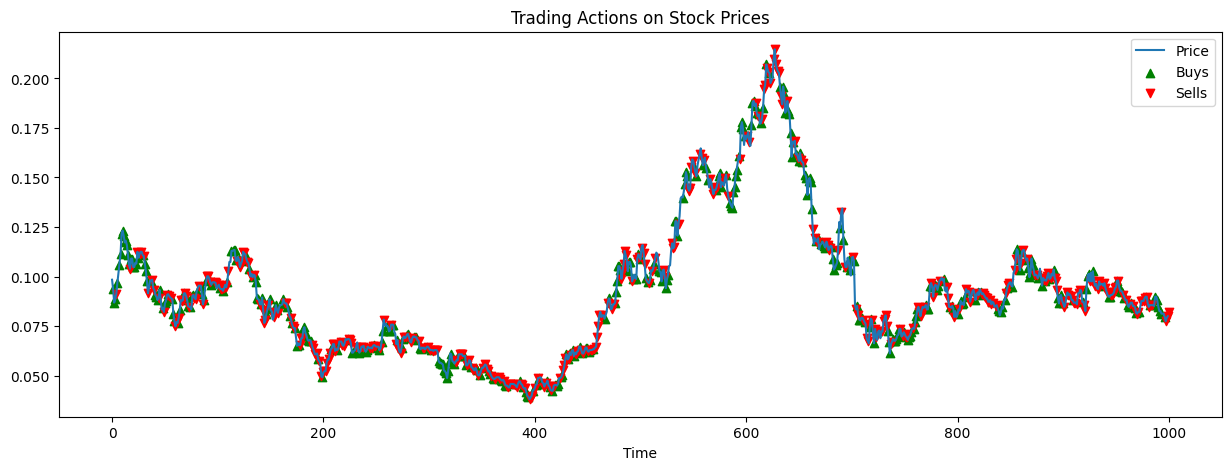

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df["Open"][0:1000], label="Price")
ax.scatter(buys_x, buys_y, marker="^", color="g", label="Buys")
ax.scatter(sells_x, sells_y, marker="v", color="r", label="Sells")
ax.set_title("Trading Actions on Stock Prices")
ax.set_xlabel("Time")
ax.legend()
plt.show()
